In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from tools import *
from MakeSyntheticSeismic import MakeSeismic, PlotSeis
from ModelGenSeis import autoencoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import reduce_mean
from tensorflow.image import ssim
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
# Generating images 
num_img = 500
# clean_signal, noise, noisy_signal = MakeSeismic(samples=num_img,img_size=128,num_events=8)
clean_signal2, noise2, noisy_signal2 = MakeSeismic(samples = num_img,img_size=256,num_events=10)

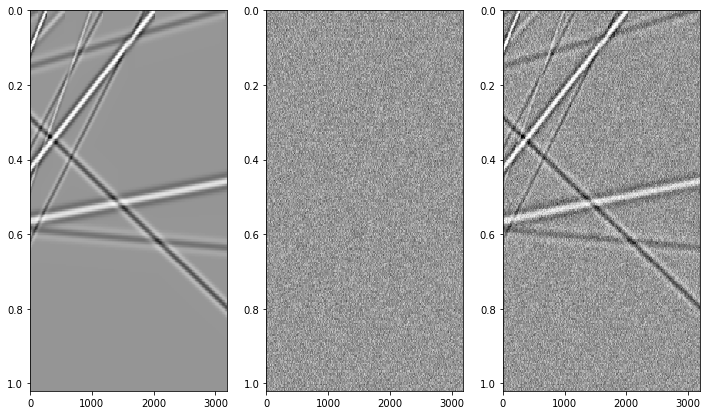

In [17]:
PlotSeis([clean_signal2,noise2,noisy_signal2],num=3)

In [18]:
# Splitting 100 images into windows to pass through the ANN autoencoder
cs_windows_conv = []
ns_windows_conv = []
n_windows_conv = []
win_size = 32
for iImg in range(num_img):
    cs_windows_conv.append(img2windows(clean_signal2[iImg,:,:,0],win_size,win_size))
    ns_windows_conv.append(img2windows(noisy_signal2[iImg,:,:,0],win_size,win_size))
    n_windows_conv.append(img2windows(noise2[iImg,:,:,0],win_size,win_size))


cs_windows_conv = np.array(cs_windows_conv)
ns_windows_conv = np.array(ns_windows_conv)
n_windows_conv = np.array(n_windows_conv)

In [19]:
ns_windows_conv_sc,ns_scalars = scale(ns_windows_conv)
cs_windows_conv_sc,cs_scalars = scale(cs_windows_conv)

In [20]:
# Generating training and testing data
# NS_train_wind, NS_test_wind, S_train_wind, S_test_wind = train_test_split(ns_windows,cs_windows, test_size=0.33, random_state = 21)
# NS_train_trc, NS_test_trc, S_train_trc, S_test_trc = train_test_split(noisy_signal2,clean_signal2, test_size=0.33, random_state = 21)

# NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv_sc,cs_windows_conv_sc, test_size=0.33, random_state = 21)
NS_train_conv, NS_test_conv, S_train_conv, S_test_conv = train_test_split(ns_windows_conv,cs_windows_conv, test_size=0.33, random_state = 21)

In [21]:
# Custom loss functions

# y_true = target = clean image = X_train
# y_pred = clean output

# max structural similarity index between original image and denoised imaged 
def ssim_loss(y_true, y_pred):
  return 1-reduce_mean(ssim(y_true, y_pred, 1.0, filter_size=5))

In [ ]:
def correlation_coefficient_loss(y_true, y_pred):
    #optional
    #x = y_true - y_pred
    #y = y_pred
    #mx = K.mean(x)
    #my = K.mean(y)
    #xm, ym = x-mx, y-my
    #r_num = K.sum(tf.multiply(xm,ym))
    #r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    #r = r_num / r_den
    #r =  corr1 - (K.maximum(K.minimum(r, 1.0), -1.0))
    
    #1
    x1 = y_true
    y1 = y_pred
    mx1 = K.mean(x1)
    my1 = K.mean(y1)
    xm1, ym1 = x1-mx1, y1-my1
    r_num1 = K.sum(tf.multiply(xm1,ym1))
    r_den1 = K.sqrt(tf.multiply(K.sum(K.square(xm1)), K.sum(K.square(ym1))))
    r1 = r_num1 / r_den1
    r1 = corr2 -  (K.maximum(K.minimum(r1, 1.0), -1.0))
    
    # Optional
    '''  
    x2 = y_true-y_pred
    y2 = y_true
    mx2 = K.mean(x2)
    my2 = K.mean(y2)
    xm2, ym2 = x2-mx2, y2-my2
    r_num2 = K.sum(tf.multiply(xm2,ym2))
    r_den2 = K.sqrt(tf.multiply(K.sum(K.square(xm2)), K.sum(K.square(ym2))))
    r2 = r_num2 / r_den2
    r2 =    corr3 - (K.maximum(K.minimum(r2, 1.0), -1.0))
    '''
    return   K.mean(K.square(y_true - y_pred)) + r1

In [22]:
# Reshaping images before they go into ANN
# NS_train_wind_resh = NS_train_wind.reshape(670*256,256)
# S_train_wind_resh = S_train_wind.reshape(670*256,256)
# NS_test_wind_resh = NS_test_wind.reshape(330*256,256)
# S_test_wind_resh = S_test_wind.reshape(330*256,256)


# Splitting out the traces into a single continuous file
# NS_train_trc_resh = NS_train_trc.reshape(670*256,256)
# S_train_trc_resh = S_train_trc.reshape(670*256,256)
# NS_test_trc_resh = NS_test_trc.reshape(330*256,256)
# S_test_trc_resh = S_test_trc.reshape(330*256,256)

# Reshaping conv windows 
NS_train_conv_resh = NS_train_conv.reshape(NS_train_conv.shape[0]*NS_train_conv.shape[1],NS_train_conv.shape[2],NS_train_conv.shape[3],1)
S_train_conv_resh = S_train_conv.reshape(S_train_conv.shape[0]*S_train_conv.shape[1],S_train_conv.shape[2],S_train_conv.shape[3],1)
NS_test_conv_resh = NS_test_conv.reshape(NS_test_conv.shape[0]*NS_test_conv.shape[1],NS_test_conv.shape[2],NS_test_conv.shape[3],1)
S_test_conv_resh = S_test_conv.reshape(S_test_conv.shape[0]*S_test_conv.shape[1],S_test_conv.shape[2],S_test_conv.shape[3],1)

In [63]:
# modelUnet = autoencoder("Unet",start_filters=8)
# modelUnetMSE = autoencoder("Unet_NoSc",start_filters=8)
# modelUnetBCE = autoencoder("Unet",start_filters=8)
# modelUpSc = autoencoder("upsc")
# modelUnetNoSc = autoencoder("Unet_NoSc",start_filters=8)

# modelANN_wind = autoencoder("ANN")
# modelANN_trc = autoencoder("ANN")
# modelANN_wind_dr = autoencoder("ANN_dr")
# modelANN_trc_dr = autoencoder("ANN_dr")

# modelUnet.compile(loss=ssim_loss,optimizer='adam',metrics=[ssim_loss])
# modelUnetMSE.compile(loss='mse',optimizer='adam')
# modelUpSc.compile(loss=ssim_loss,optimizer='adam',metrics=[ssim_loss])
# modelUnetNoSc.compile(loss=ssim_loss,optimizer='adam',metrics=[ssim_loss])
# modelUnetMSE.compile(loss='mse',optimizer='adam')
# modelUnetBCE.compile(loss='binary_crossentropy',optimizer='adam')

# modelANN_wind.compile(loss='mse',optimizer='adam')
# modelANN_trc.compile(loss='mse',optimizer='adam')

# modelANN_wind_dr.compile(loss='mse',optimizer='adam')
# modelANN_trc_dr.compile(loss='mse',optimizer='adam')


# modelConv3x3 = autoencoder("upsc",kernel=(3,3),input_size=(32,32,1))
# modelConv4x4 = autoencoder("upsc",kernel=(4,4),input_size=(32,32,1))
# modelConv5x5 = autoencoder("upsc",kernel=(5,5),input_size=(32,32,1))

modelConv3x3_SSIM = autoencoder("upsc",kernel=(3,3),input_size=(32,32,1))


# modelConv3x3.compile(loss='mse',optimizer='adam')
# modelConv4x4.compile(loss='mse',optimizer='adam')
# modelConv5x5.compile(loss='mse',optimizer='adam')

modelConv3x3_SSIM.compile(loss=ssim_loss,optimizer='adam')


In [25]:
# Creating callback for training
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.002,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [26]:
# from tensorflow.keras.callbacks import ModelCheckpoint
# model_checkpoint_callback = ModelCheckpoint(
#     filepath='checkpoint_filepath',
#     save_weights_only=True,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)

In [65]:
# batch_size= 128
# epochs = 100
# modelConv3x3_hist = modelConv3x3.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

In [66]:
batch_size= 128
epochs = 100
modelConv3x3_SSIM_hist = modelConv3x3_SSIM.fit(NS_train_conv_resh, S_train_conv_resh, batch_size = batch_size, epochs = epochs,shuffle=True,validation_data =(NS_test_conv_resh,S_test_conv_resh),use_multiprocessing=True)

Epoch 1/100
168/168 [==============================] - 50s 295ms/step - loss: 0.4111 - val_loss: 0.4081
Epoch 2/100
168/168 [==============================] - 50s 295ms/step - loss: 0.4043 - val_loss: 0.4081
Epoch 3/100
168/168 [==============================] - 50s 297ms/step - loss: 0.4043 - val_loss: 0.4081
Epoch 4/100
 36/168 [=====>........................] - ETA: 33s - loss: 0.4057

KeyboardInterrupt: 

In [28]:
# _2 = 128 batch size ** best ** 
# _3 = 64 batch size 
# _4 = 128 batch size with new correct noise level input
# hists = pd.DataFrame(modelANN_trc_hist.history)
# hists["model"]="ANN_trc"
hists = pd.read_csv('/Users/Graham/Documents/Programming/GitHub/ML/AutoEncoderImageDenoise/models/perf/hists.csv')
hists= store_hist(hists,pd.DataFrame(modelConv3x3_hist.history),"Conv3x3_v2_500img")
# hists= store_hist(hists,pd.DataFrame(modelConv4x4_hist.history),'Conv4x4')
# hists= store_hist(hists,pd.DataFrame(modelANN_wind_dr_hist.history),'ANN_wind_dr')
# hists= store_hist(hists,pd.DataFrame(modelANN_trc_dr_hist.history),'ANN_trc_dr')


hists.to_csv('/Users/Graham/Documents/Programming/GitHub/ML/AutoEncoderImageDenoise/models/perf/hists.csv')


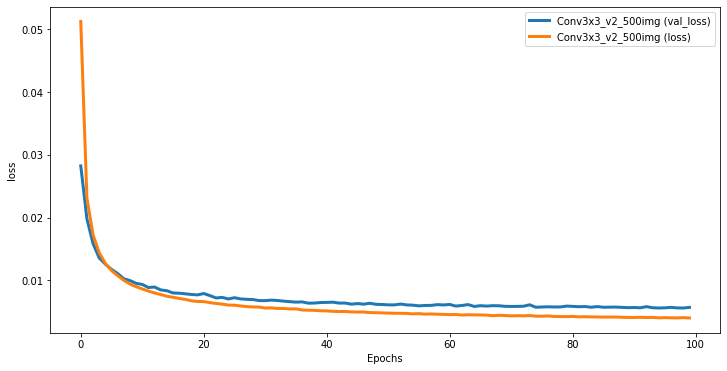

In [62]:
plot_perf(hists,['Conv3x3_v2_500img'],['val_loss','loss'])

In [30]:
# modelUnetMSE.save('./models/UnetMSE_16filt')
# modelUnetMSE.save('./models/UnetMSE_8filt')
# modelANN_wind.save('./models/ANN_wind_4')
# modelANN_trc.save('./models/ANN_trc_4')

# modelConv3x3.save('./models/UpscConv3x3')
# modelConv4x4.save('./models/UpscConv4x4')

modelConv3x3.save('./models/UpscConv3x3_v2')


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [36]:
from tensorflow.keras.models import load_model
modelANN_trc_v1 = load_model('./models/ANN_trc_2')
modelANN_wind_v1 = load_model('./models/ANN_wind_2')

In [31]:
# Predicting

# pred = modelUnet.predict(NS_test)
# pred2 = modelUnet.predict(ns_test)
# predmse = modelUnetMSE.predict(NS_test_nosc)
# predmse3 = modelUnetMSE.predict(NS_test_nosc)

# pred_upsc = modelUpSc.predict(ns_test)
# pred_nosc = modelUnetNoSc.predict(NS_test_nosc)

# predANN_trc_v1 = modelANN_trc_v1.predict(NS_test_trc_resh)
# predANN_trc_v2 = modelANN_trc.predict(NS_test_trc_resh)

# predANN_wind_v1 = modelANN_wind_v1.predict(NS_test_wind_resh)
# predANN_wind_v2 = modelANN_wind.predict(NS_test_wind_resh)

# predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)
# predConv_wind_4x4 = modelConv4x4.predict(NS_test_conv_resh)

predConv_wind_3x3 = modelConv3x3.predict(NS_test_conv_resh)


In [52]:
predConv_wind_v1.shape[0]/64

33.0

In [41]:
# Reshaping predictions
predANN_wind_v1_resh = predANN_wind_v1.reshape(int(predANN_wind_v1.shape[0]/256),256,16,16)
predANN_wind_v2_resh = predANN_wind_v2.reshape(int(predANN_wind_v2.shape[0]/256),256,16,16)


decoded_imgANN_wind_v1 = []
decoded_imgANN_wind_v2 = []

orig_noisy = []
orig_clean = []
for iImg in range(330):
    decoded_imgANN_wind_v1.append(windows2img(predANN_wind_v1_resh[iImg],256,256))
    decoded_imgANN_wind_v2.append(windows2img(predANN_wind_v2_resh[iImg],256,256))
    orig_noisy.append(windows2img(NS_test_wind[iImg],256,256))
    orig_clean.append(windows2img(S_test_wind[iImg],256,256))

decoded_imgANN_wind_v1 = np.array(decoded_imgANN_wind_v1)
decoded_imgANN_wind_v2 = np.array(decoded_imgANN_wind_v2)

orig_noisy = np.array(orig_noisy)
orig_clean = np.array(orig_clean)

In [33]:
def pred_resh(data,output_size,num_wind,wind_size):

    # Reshaping predictions
    data_resh= data.reshape(int(data.shape[0]/num_wind),num_wind,wind_size,wind_size)

    img = []
    orig_noisy = []
    orig_clean = []
    for iImg in range(data_resh.shape[0]):
        img.append(windows2img(data_resh[iImg],output_size,output_size))
        orig_noisy.append(windows2img(NS_test_conv[iImg],output_size,output_size))
        orig_clean.append(windows2img(S_test_conv[iImg],output_size,output_size))

    img = np.array(img)
    orig_noisy = np.array(orig_noisy)
    orig_clean = np.array(orig_clean)

    return img


In [34]:
decodedimg_conv3x3 = pred_resh(predConv_wind_3x3,output_size=256,num_wind=64,wind_size=32)
# decodedimg_conv4x4 = pred_resh(predConv_wind_4x4,output_size=256,num_wind=64,wind_size=32)

In [45]:
# Reshaping predictions
orig_noisy = []
orig_clean = []
for iImg in range(165):
    orig_noisy.append(windows2img(NS_test_conv[iImg],256,256))
    orig_clean.append(windows2img(S_test_conv[iImg],256,256))

orig_noisy = np.array(orig_noisy)
orig_clean = np.array(orig_clean)

Text(0.5, 1.0, 'Diff Window')

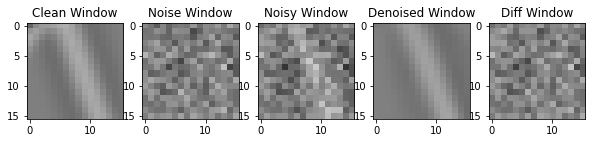

In [64]:
img = 6
wind = 5

plt.figure(figsize=(10,10))
plt.subplot(1,5,1)
plt.imshow(S_test_wind[img,wind],vmin=-1.5,vmax=1.5)
plt.gray()
plt.title('Clean Window')
plt.subplot(1,5,2)
plt.imshow(NS_test_wind[img,wind]-S_test_wind[img,wind],vmin=-1.5,vmax=1.5)
plt.gray()
plt.title('Noise Window')
plt.subplot(1,5,3)
plt.imshow(NS_test_wind[img,wind],vmin=-1.5,vmax=1.5)
plt.gray()
plt.title('Noisy Window')
plt.subplot(1,5,4)
plt.imshow(predANN_wind_v1_resh[img,wind],vmin=-1.5,vmax=1.5)
plt.gray()
plt.title('Denoised Window')
plt.subplot(1,5,5)
plt.imshow(NS_test_wind[img,wind]-predANN_wind_v1_resh[img,wind],vmin=-1.5,vmax=1.5)
plt.gray()
plt.title('Diff Window')

In [45]:
decoded_imgANN_trc_v1 = predANN_trc_v1.reshape(330,256,256,1)
decoded_imgANN_trc_v2 = predANN_trc_v2.reshape(330,256,256,1)

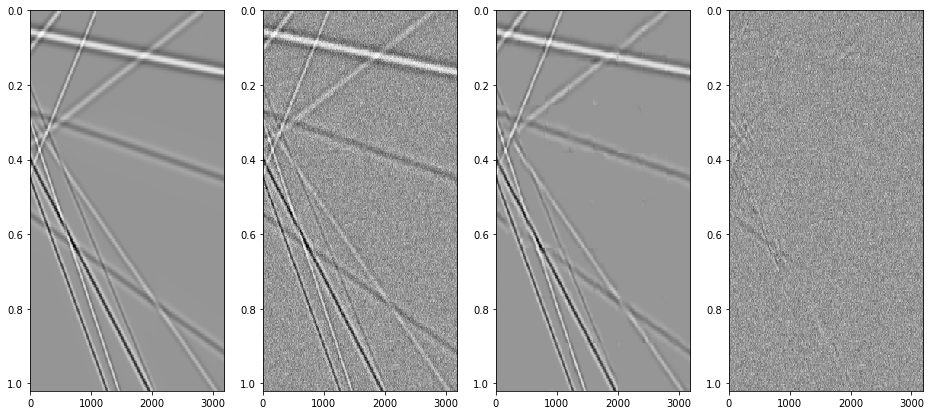

In [68]:
PlotSeis([orig_clean,orig_noisy,decodedimg_conv3x3,orig_noisy-decodedimg_conv3x3],num=23)